In [1]:
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import ultraplot as uplt

# Statsmodels imports
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def prepare_data(prcp_filepath, tmax_filepath, landcover_filepath, area_filepath):
    prcp = pd.read_csv(prcp_filepath)
    tmax = pd.read_csv(tmax_filepath)
    landcover = pd.read_csv(landcover_filepath)
    area = pd.read_csv(area_filepath)

    dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)
    county = gpd.read_file('./Data/counties_2021.geojson')
    county = county.to_crs(dest_crs)[['ADM2_NAME', 'geometry']]

    combined = gpd.GeoDataFrame(pd.concat([prcp, tmax, landcover, area, county], axis=1))
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    combined['total_forest'] = combined['deciduous'] + combined['evergreen'] + combined['mixed']
    combined['perc_deciduous'] = combined['deciduous']/combined['total_forest']
    combined['perc_evergreen'] = combined['evergreen']/combined['total_forest']
    combined['perc_mixed'] = combined['mixed']/combined['total_forest']
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    def standardize(x):
        return (x - x.mean()) / x.std()

    combined['z_prcp_total'] = standardize(combined['total'])
    combined['z_prcp_anom'] = standardize(combined['anom'])
    combined['z_tmax_mean'] = standardize(combined['tmax_mean'])
    combined['z_tmax_anom'] = standardize(combined['tmax_anom'])
    combined['z_perc_deciduous'] = standardize(combined['perc_deciduous'])
    combined['z_perc_evergreen'] = standardize(combined['perc_evergreen'])
    combined['z_perc_mixed'] = standardize(combined['perc_mixed'])
    combined['z_perc_defol_area'] = standardize(combined['perc_defol_area'])
    
    return combined

In [3]:
def partial_regression(ax, data, x_residual, x_initial, y, xlabel, mls_pvalue, ms=10, ls='dashed'):
    # Compute x residuals
    formula = x_residual + ' ~ ' + ' + '.join(x_initial)
    x_reg = sm.ols(formula=formula, data=data).fit()

    predicted = x_reg.params['Intercept']
    for x in x_initial:
        predicted += x_reg.params[x]*data[x]
    data['x_residuals'] = data[x_residual] - predicted
    
    # Compute y residuals
    formula = y + ' ~ ' + ' + '.join(x_initial)
    y_reg = sm.ols(formula=formula, data=data).fit()
    
    predicted = y_reg.params['Intercept']
    for x in x_initial:
        predicted += y_reg.params[x]*data[x]
    data['y_residuals'] = data[y] - predicted
    
    # Compute partial regression
    res_reg = sm.ols('y_residuals ~ x_residuals', data=data).fit()

    # Plot residuals
    ax.scatter(data['x_residuals'], data['y_residuals'], color='gray', markersize=ms)

    x = np.array(ax.get_xlim())
    y_pred = res_reg.params['Intercept'] + res_reg.params['x_residuals']*x

    print(res_reg.params['x_residuals'])

    # Plot partial regression
    ax.plot(x, y_pred, color='black', linestyle=ls)
    ax.format(xlabel=xlabel, ylabel='Residuals',
              upperrighttitle=f'slope={res_reg.params['x_residuals']:.4f}\np={mls_pvalue:.4f}')

## 2020 anomalous conditions versus one year defoliation

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.164
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.124
Time:                        13:28:40   Log-Likelihood:                 219.07
No. Observations:                  62   AIC:                            -432.1
Df Residuals:                      59   BIC:                            -425.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0085      0.001      9.203      

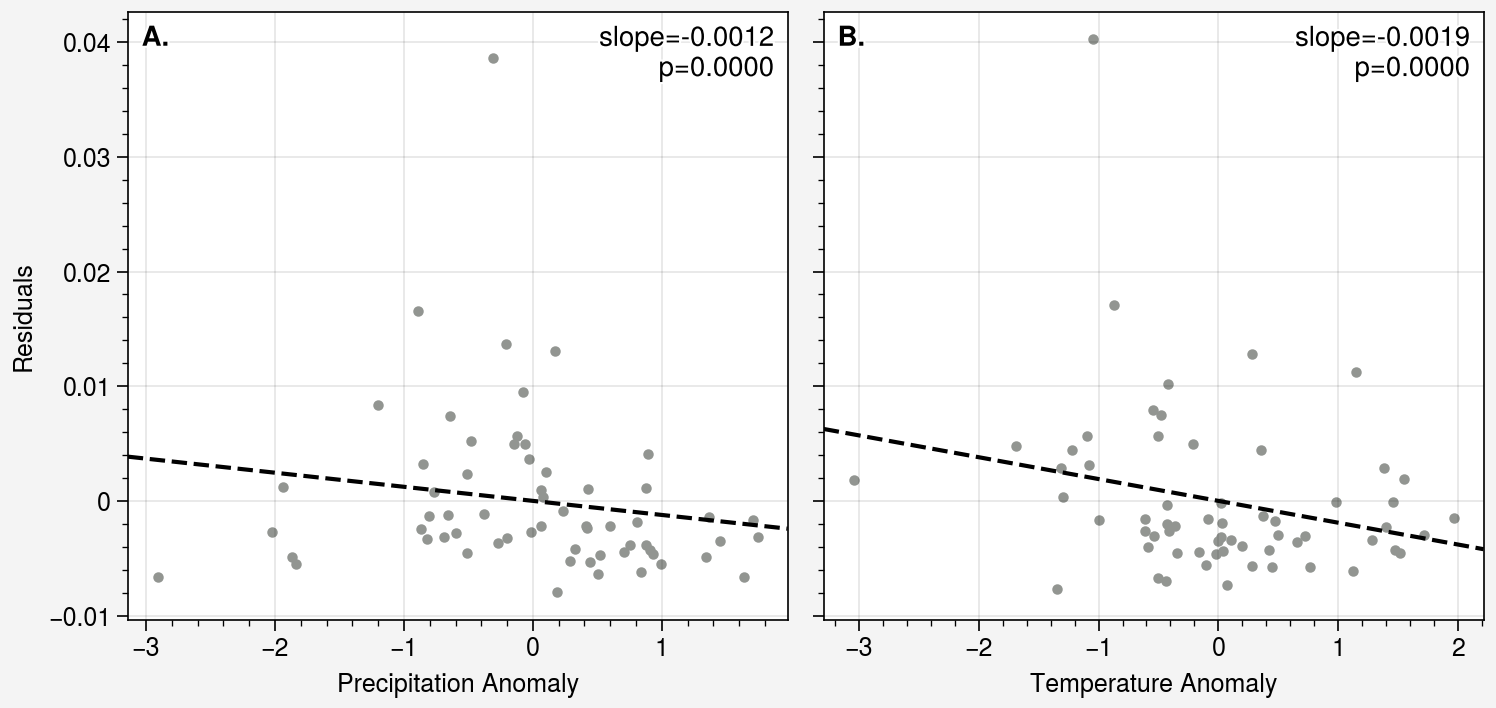

In [4]:
combined = prepare_data('./Data/Enviro/prcp_twelve_month_county_2020.csv', 
                        './Data/Enviro/tmax_twelve_month_county_2020.csv', 
                        './Data/Enviro/landcover_distribution.csv', 
                        './Data/Enviro/defol_area_county_2020.csv')

mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom', data=combined)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], combined, 'z_prcp_anom', ['z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly', 0)
partial_regression(axes[1], combined, 'z_tmax_anom', ['z_prcp_anom'], 'perc_defol_area', 'Temperature Anomaly', 0)

## 2021 anomalous conditions versus one year defoliation

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8408
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.436
Time:                        13:28:45   Log-Likelihood:                 104.30
No. Observations:                  62   AIC:                            -202.6
Df Residuals:                      59   BIC:                            -196.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0366      0.006      6.243      

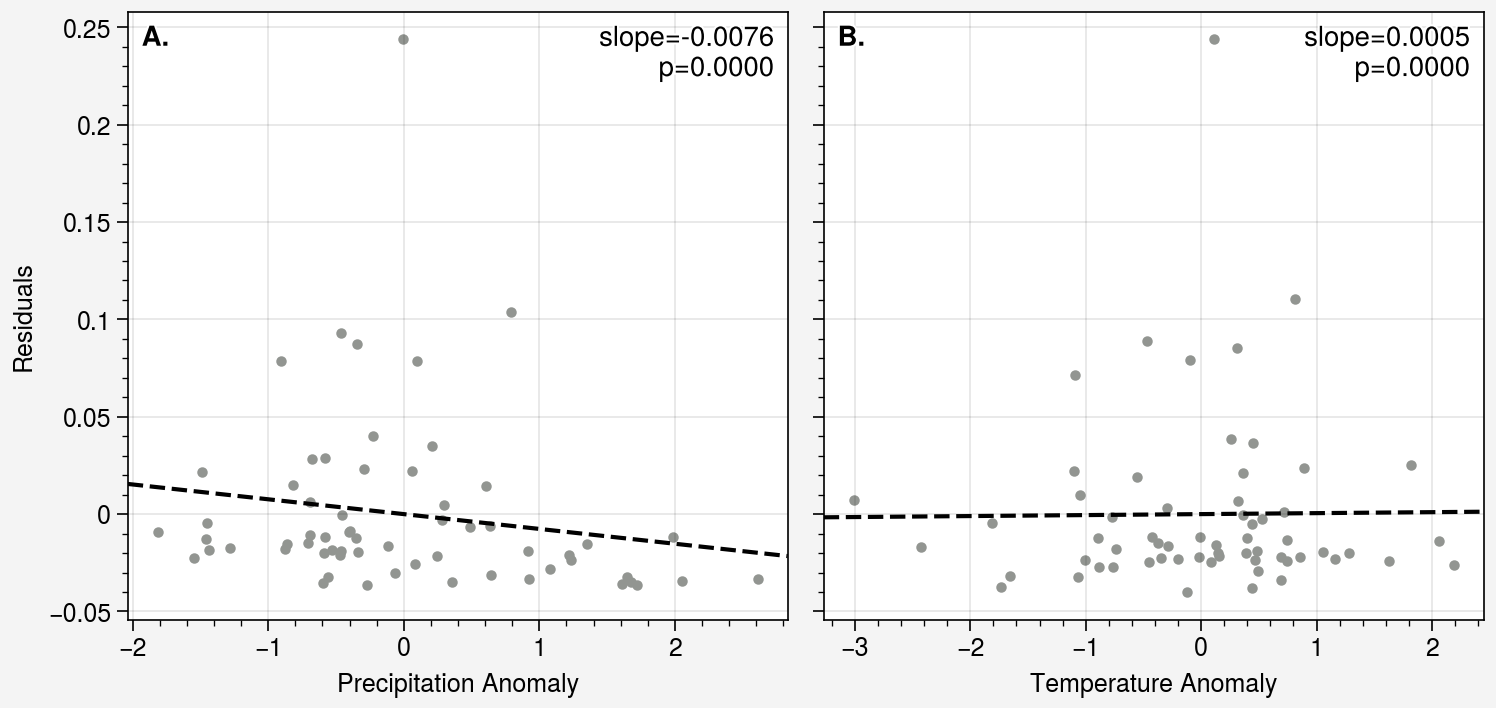

In [5]:
combined = prepare_data('./Data/Enviro/prcp_twelve_month_county_2021.csv', 
                        './Data/Enviro/tmax_twelve_month_county_2021.csv', 
                        './Data/Enviro/landcover_distribution.csv', 
                        './Data/Enviro/defol_area_county_2021.csv')

mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom', data=combined)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], combined, 'z_prcp_anom', ['z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly', 0)
partial_regression(axes[1], combined, 'z_tmax_anom', ['z_prcp_anom'], 'perc_defol_area', 'Temperature Anomaly', 0)

## 2022 anomalous conditions versus one year defoliation

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.939
Date:                Thu, 01 May 2025   Prob (F-statistic):             0.0607
Time:                        13:28:50   Log-Likelihood:                 160.63
No. Observations:                  62   AIC:                            -315.3
Df Residuals:                      59   BIC:                            -308.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0157      0.002      6.656      

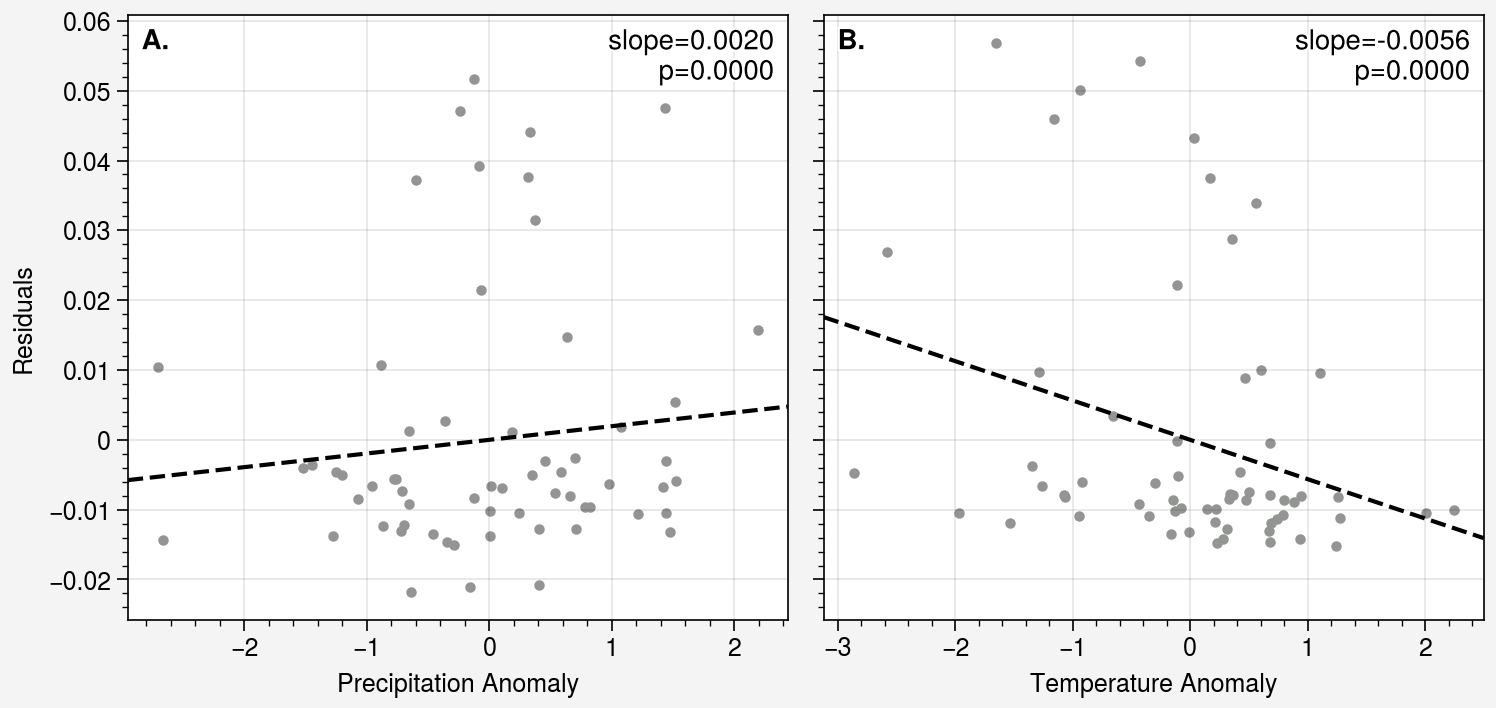

In [6]:
combined = prepare_data('./Data/Enviro/prcp_twelve_month_county_2022.csv', 
                        './Data/Enviro/tmax_twelve_month_county_2022.csv', 
                        './Data/Enviro/landcover_distribution.csv', 
                        './Data/Enviro/defol_area_county_2022.csv')

mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom', data=combined)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], combined, 'z_prcp_anom', ['z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly', 0)
partial_regression(axes[1], combined, 'z_tmax_anom', ['z_prcp_anom'], 'perc_defol_area', 'Temperature Anomaly', 0)

## 2023 anomalous conditions versus one year defoliation

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.074
Date:                Thu, 01 May 2025   Prob (F-statistic):             0.0537
Time:                        13:28:55   Log-Likelihood:                 111.63
No. Observations:                  62   AIC:                            -217.3
Df Residuals:                      59   BIC:                            -210.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0466      0.005      8.957      

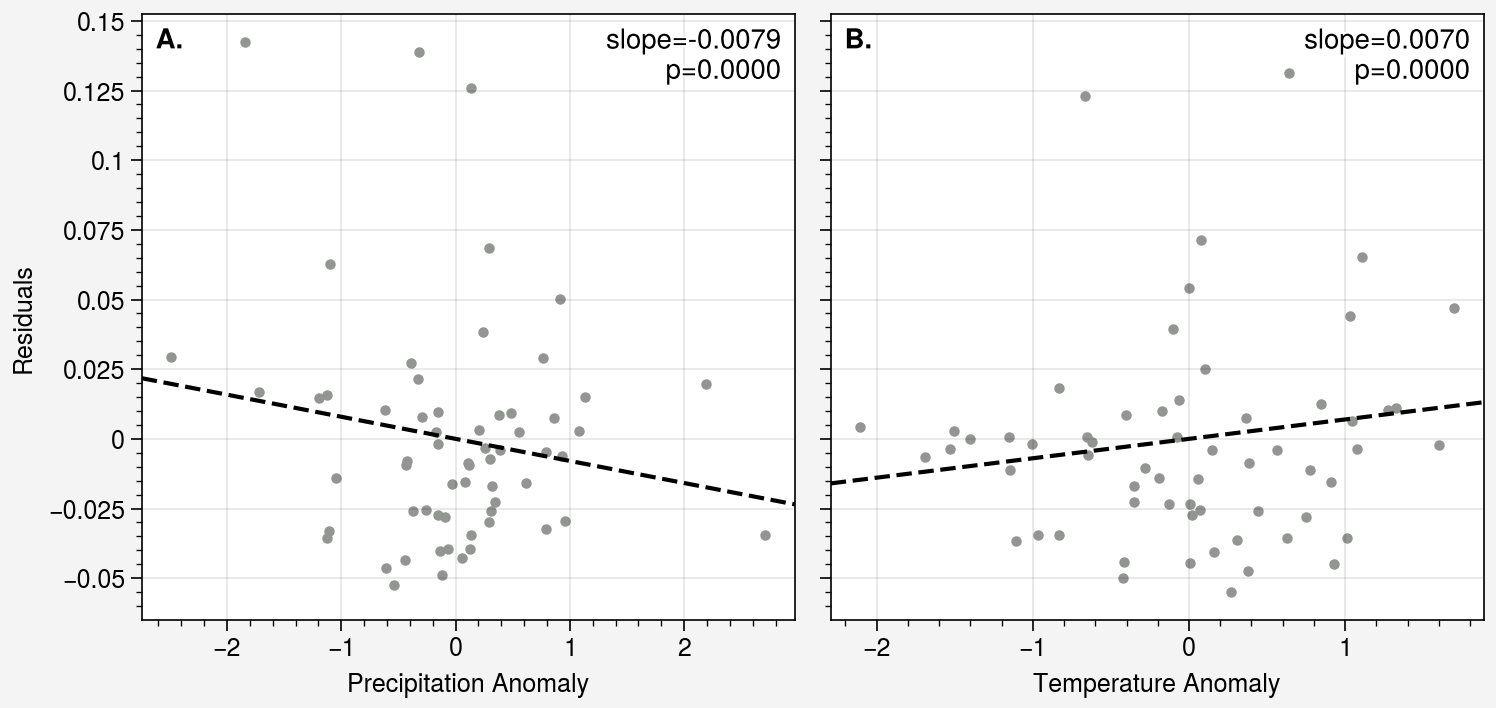

In [7]:
combined = prepare_data('./Data/Enviro/prcp_twelve_month_county_2023.csv', 
                        './Data/Enviro/tmax_twelve_month_county_2023.csv', 
                        './Data/Enviro/landcover_distribution.csv', 
                        './Data/Enviro/defol_area_county_2023.csv')

mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom', data=combined)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], combined, 'z_prcp_anom', ['z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly', 0)
partial_regression(axes[1], combined, 'z_tmax_anom', ['z_prcp_anom'], 'perc_defol_area', 'Temperature Anomaly', 0)

## All years

In [8]:
defol_2020 = prepare_data('./Data/Enviro/prcp_twelve_month_county_2021.csv', 
                          './Data/Enviro/tmax_twelve_month_county_2022.csv', 
                          './Data/Enviro/landcover_distribution.csv', 
                          './Data/Enviro/defol_area_county_2023.csv')
defol_2021 = prepare_data('./Data/Enviro/prcp_twelve_month_county_2021.csv', 
                          './Data/Enviro/tmax_twelve_month_county_2021.csv', 
                          './Data/Enviro/landcover_distribution.csv', 
                          './Data/Enviro/defol_area_county_2021.csv')
defol_2022 = prepare_data('./Data/Enviro/prcp_twelve_month_county_2022.csv', 
                          './Data/Enviro/tmax_twelve_month_county_2022.csv', 
                          './Data/Enviro/landcover_distribution.csv', 
                          './Data/Enviro/defol_area_county_2022.csv')
defol_2023 = prepare_data('./Data/Enviro/prcp_twelve_month_county_2023.csv', 
                          './Data/Enviro/tmax_twelve_month_county_2023.csv', 
                          './Data/Enviro/landcover_distribution.csv', 
                          './Data/Enviro/defol_area_county_2023.csv')

defol = pd.concat([defol_2020, defol_2021, defol_2022, defol_2023])

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.08423
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.919
Time:                        13:29:35   Log-Likelihood:                 442.45
No. Observations:                 248   AIC:                            -878.9
Df Residuals:                     245   BIC:                            -868.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0364      0.003     14.013      

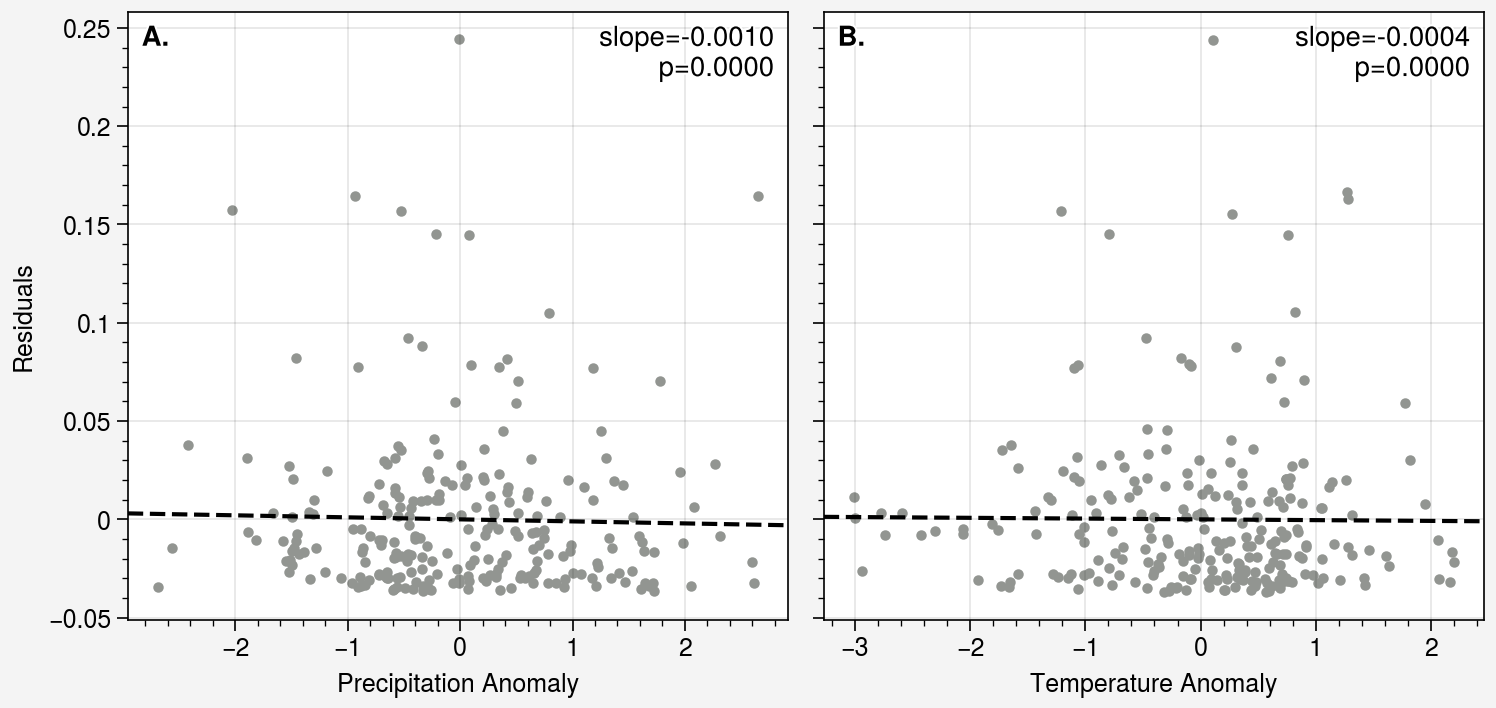

In [10]:
mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom', data=defol)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], defol, 'z_prcp_anom', ['z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly', 0)
partial_regression(axes[1], defol, 'z_tmax_anom', ['z_prcp_anom'], 'perc_defol_area', 'Temperature Anomaly', 0)

## Just 2021 and 2023

In [11]:
defol_21_23 = pd.concat([defol_2021, defol_2023])

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.345
Date:                Thu, 01 May 2025   Prob (F-statistic):             0.0386
Time:                        13:29:37   Log-Likelihood:                 214.29
No. Observations:                 124   AIC:                            -422.6
Df Residuals:                     121   BIC:                            -414.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0416      0.004     10.647      

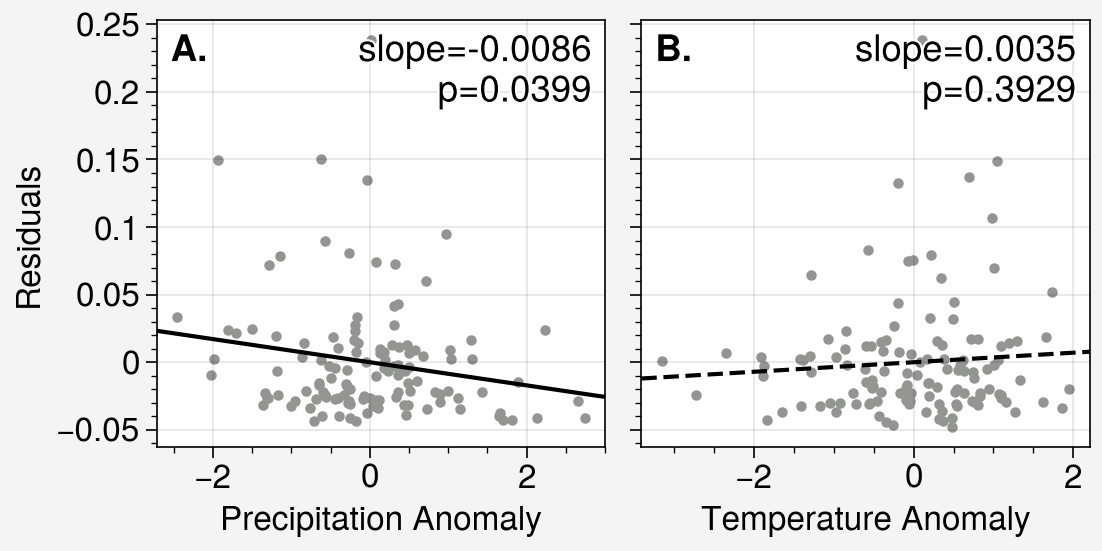

In [12]:
mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom', data=defol_21_23)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("140mm", "70mm"), fontsize=12)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], defol_21_23, 'z_prcp_anom', ['z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly', res.pvalues['z_prcp_anom'], ls='solid')
partial_regression(axes[1], defol_21_23, 'z_tmax_anom', ['z_prcp_anom'], 'perc_defol_area', 'Temperature Anomaly', res.pvalues['z_tmax_anom'])

fig.savefig('./Figures/Enviro/anomaly_regression.png')

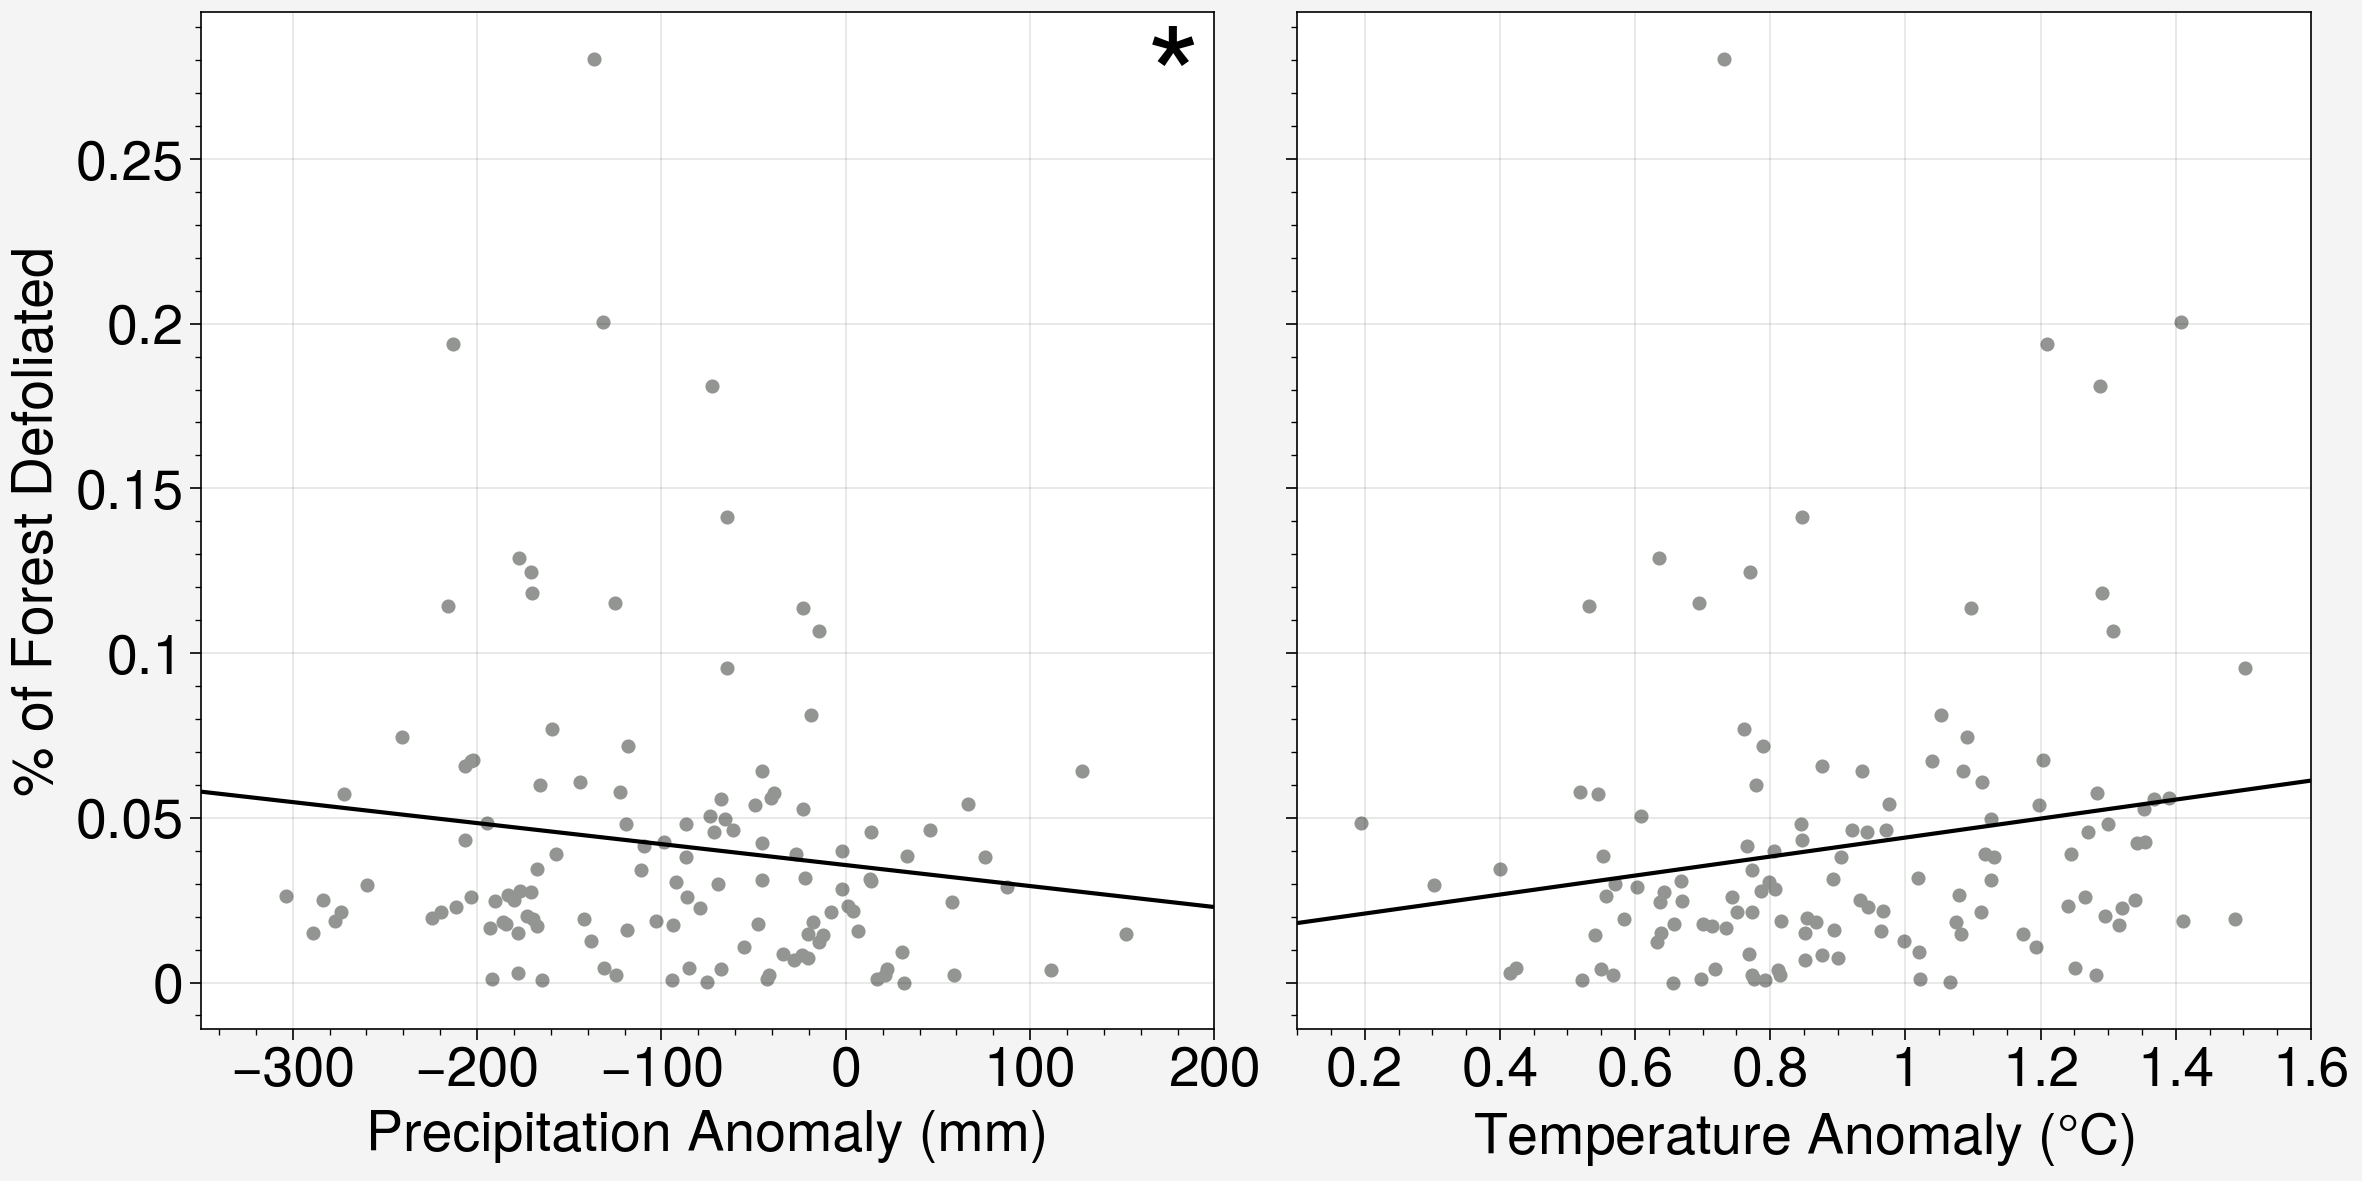

In [13]:
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("300mm", "150mm"), fontsize=20)

mod = sm.ols(formula='perc_defol_area ~ anom', data=defol_21_23)

res = mod.fit()

x = np.array([-350, 200])
y = res.params['Intercept'] + res.params['anom']*x

axes[0].scatter(defol_21_23['anom'], defol_21_23['perc_defol_area'], color='gray', markersize=20)
axes[0].plot(x, y, color='black')
axes[0].format(xlabel='Precipitation Anomaly (mm)', ylabel='% of Forest Defoliated', titleloc='ur', title='*', title_kw={'fontsize': 50})

mod = sm.ols(formula='perc_defol_area ~ tmax_anom', data=defol_21_23)

res = mod.fit()

x = np.array([0.1, 1.6])
y = res.params['Intercept'] + res.params['tmax_anom']*x

axes[1].scatter(defol_21_23['tmax_anom'], defol_21_23['perc_defol_area'], color='gray', markersize=20)
axes[1].plot(x, y, color='black')
axes[1].format(xlabel=r'Temperature Anomaly ($\degree$C)', ylabel='% of Forest Defoliated')

fig.savefig('./Figures/Enviro/anomaly_regression_unscaled.png')

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.726
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.134
Time:                        13:49:01   Log-Likelihood:                 215.34
No. Observations:                 124   AIC:                            -418.7
Df Residuals:                     118   BIC:                            -401.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0416      0.004  

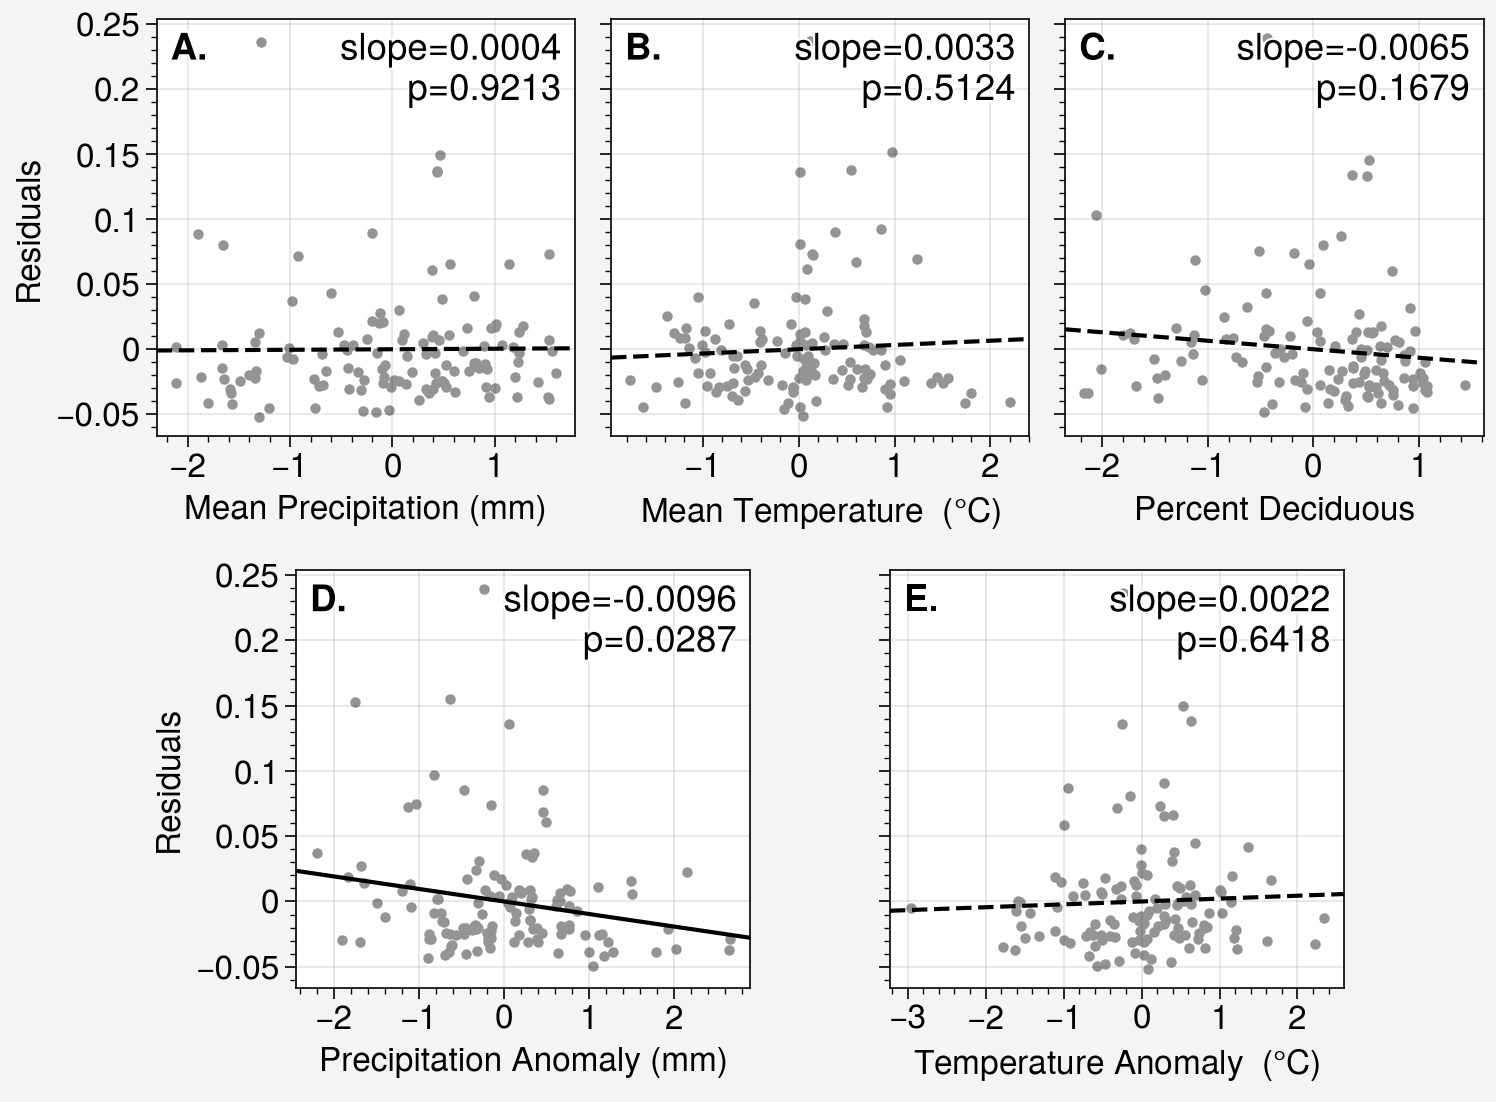

In [31]:
mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom + z_prcp_total + z_tmax_mean + z_perc_deciduous', data=defol_21_23)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots([[1, 1, 1, 2, 2, 2, 3, 3, 3], [0, 4, 4, 4, 0, 5, 5, 5, 0]], sharex=False, figsize=("190mm", "140mm"), fontsize=12)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], defol_21_23, 'z_prcp_total', ['z_tmax_mean', 'z_perc_deciduous', 'z_prcp_anom','z_tmax_anom'], 'perc_defol_area', 'Mean Precipitation (mm)', res.pvalues['z_prcp_total'])
partial_regression(axes[1], defol_21_23, 'z_tmax_mean', ['z_prcp_total', 'z_perc_deciduous', 'z_prcp_anom', 'z_tmax_anom'], 'perc_defol_area', r'Mean Temperature  ($\degree$C)', res.pvalues['z_tmax_mean'])
partial_regression(axes[2], defol_21_23, 'z_perc_deciduous', ['z_prcp_total', 'z_tmax_mean', 'z_prcp_anom', 'z_tmax_anom'], 'perc_defol_area', 'Percent Deciduous', res.pvalues['z_perc_deciduous'])
partial_regression(axes[3], defol_21_23, 'z_prcp_anom', ['z_prcp_total', 'z_tmax_mean', 'z_perc_deciduous', 'z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly (mm)', res.pvalues['z_prcp_anom'], ls='solid')
partial_regression(axes[4], defol_21_23, 'z_tmax_anom', ['z_prcp_total', 'z_tmax_mean', 'z_perc_deciduous', 'z_prcp_anom'], 'perc_defol_area', r'Temperature Anomaly  ($\degree$C)', res.pvalues['z_tmax_anom'])

fig.savefig('./Figures/Enviro/full_regression.png')

In [32]:
to_include = res.params[1:].sort_values()

to_include.index

Index(['z_prcp_anom', 'z_perc_deciduous', 'z_prcp_total', 'z_tmax_anom',
       'z_tmax_mean'],
      dtype='object')

In [62]:
labels = ['Precipitation\n Anomaly', 'Percent\n Deciduous', 'Mean\n Precipitation', 'Temperature\n Anomaly', 'Mean\n Temperature']

C:\Users\camer\AppData\Local\Temp\ipykernel_30556\4152903079.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].hlines(len(to_include) - idx - 1, ci[1][0], ci[1][1], color=['black', 'red'][colors[idx]], zorder=1, linewidth=1)


-0.009606868923043367


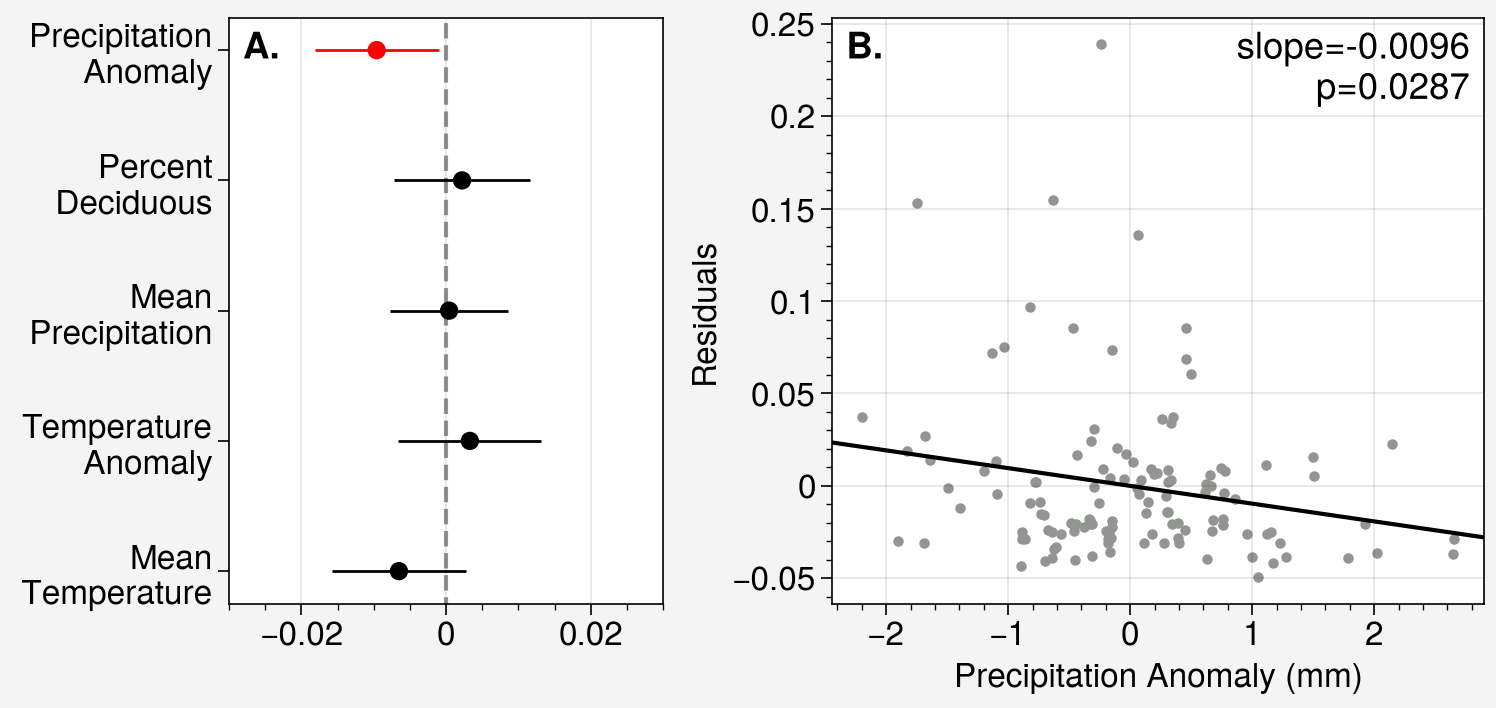

In [67]:
to_include = res.params[1:]
colors = (res.pvalues[1:] < 0.05).astype(int)

fig, axes = uplt.subplots([[0, 1, 1, 2, 2, 2]], figsize=("190mm", "90mm"), fontsize=12, sharey=False)

axes.format(abc='A.', abcloc='upper left')

axes[0].vlines(0, -1, len(to_include), color='gray', zorder=0, linestyle='dashed')

# add the confidence interval error bars
for idx, ci in enumerate(res.conf_int().loc[to_include.index].iterrows()):
    axes[0].hlines(len(to_include) - idx - 1, ci[1][0], ci[1][1], color=['black', 'red'][colors[idx]], zorder=1, linewidth=1)

axes[0].scatter(to_include, range(len(to_include)-1, -1, -1), color=colors, cmap=['black', 'red'], zorder=1)
axes[0].format(ylocator=range(len(to_include)-1, -1, -1), yformatter=labels, yminorlocator='null', ylim=[-0.25, len(to_include)-0.75], 
          xlim=[-0.03, 0.03], xlocator=[-0.02, 0, 0.02], ygrid=False)

partial_regression(axes[1], defol_21_23, 'z_prcp_anom', ['z_prcp_total', 'z_tmax_mean', 'z_perc_deciduous', 'z_tmax_anom'], 'perc_defol_area', 'Precipitation Anomaly (mm)', res.pvalues['z_prcp_anom'], ls='solid')
axes[1].format(fontsize=12)

fig.savefig('./Figures/Enviro/coefficients_prcp_anom.png')

In [30]:
fdrcorrection([0.9213, 0.5124, 0.1679, 0.0287, 0.6418], alpha=0.15, method='indep', is_sorted=False)

(array([False, False, False,  True, False]),
 array([0.9213 , 0.80225, 0.41975, 0.1435 , 0.80225]))

# Average condition effects

In [14]:
avg_defol = defol_2020.copy()
avg_defol['perc_defol_area'] = (defol_2020['perc_defol_area'] +
                                defol_2021['perc_defol_area'] +
                                defol_2022['perc_defol_area'] +
                                defol_2023['perc_defol_area'])/4

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.604
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.198
Time:                        13:31:16   Log-Likelihood:                 144.12
No. Observations:                  62   AIC:                            -280.2
Df Residuals:                      58   BIC:                            -271.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0364      0.003  

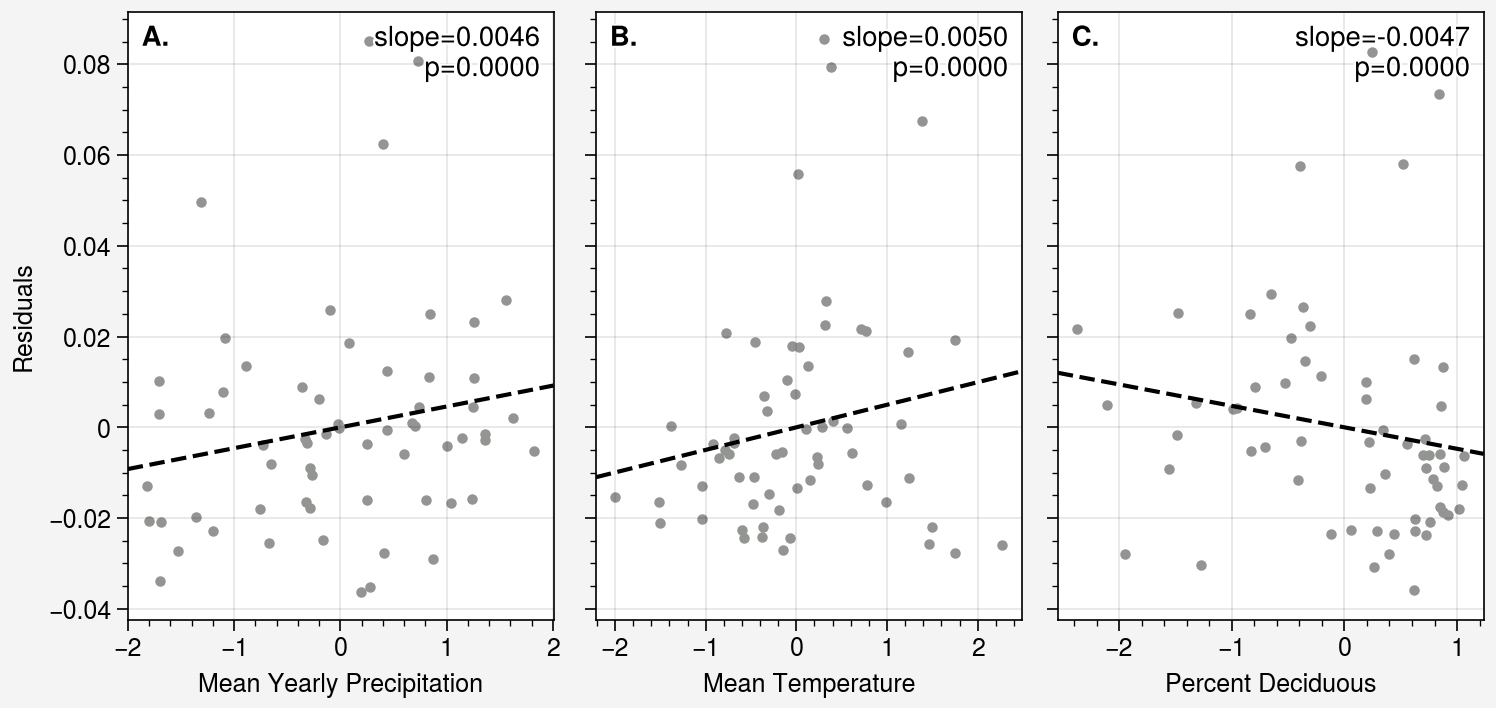

In [16]:
mod = sm.ols(formula='perc_defol_area ~  z_prcp_total + z_tmax_mean + z_perc_deciduous', data=avg_defol)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], avg_defol, 'z_prcp_total', ['z_tmax_mean', 'z_perc_deciduous'], 'perc_defol_area', 'Mean Yearly Precipitation', 0)
partial_regression(axes[1], avg_defol, 'z_tmax_mean', ['z_prcp_total', 'z_perc_deciduous'], 'perc_defol_area', 'Mean Temperature', 0)
partial_regression(axes[2], avg_defol, 'z_perc_deciduous', ['z_prcp_total', 'z_tmax_mean'], 'perc_defol_area', 'Percent Deciduous', 0)

In [17]:
avg_defol = defol_2020.copy()
avg_defol['perc_defol_area'] = (defol_2021['perc_defol_area'] +
                                defol_2023['perc_defol_area'])/2

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6861
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.564
Time:                        13:31:45   Log-Likelihood:                 136.17
No. Observations:                  62   AIC:                            -264.3
Df Residuals:                      58   BIC:                            -255.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0416      0.004  

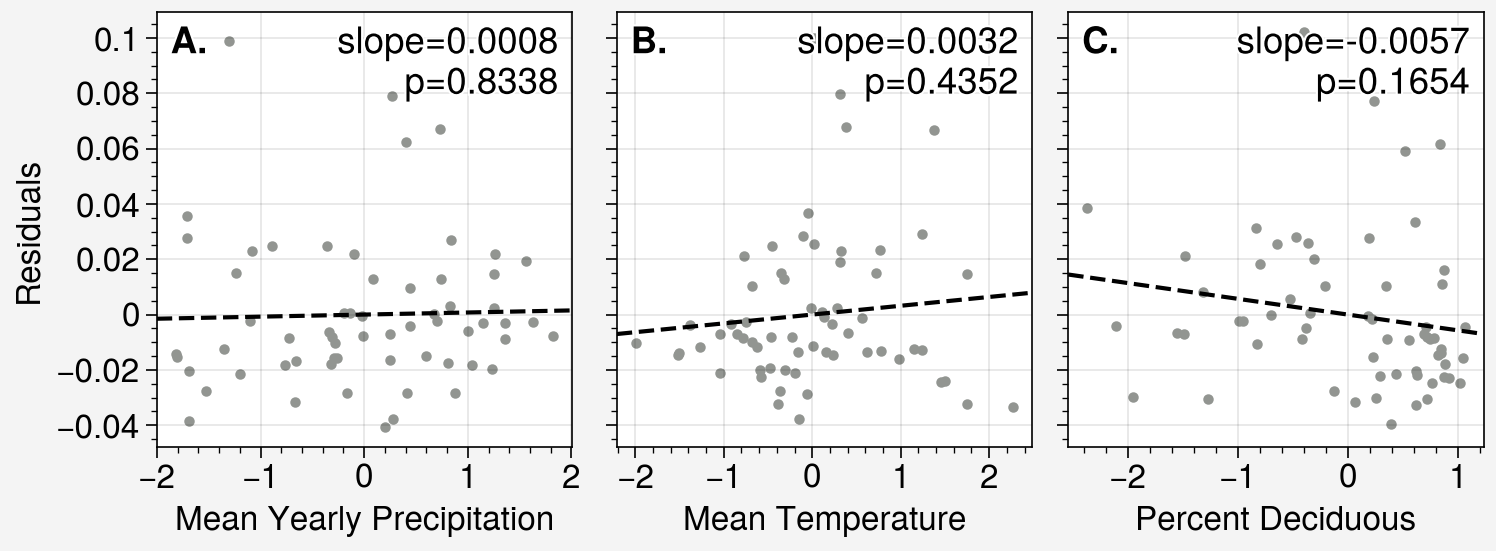

In [18]:
mod = sm.ols(formula='perc_defol_area ~  z_prcp_total + z_tmax_mean + z_perc_deciduous', data=avg_defol)

res = mod.fit()

print(res.summary())

# Partial regressions
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("190mm", "70mm"), fontsize=12)

axes.format(abc='A.', abcloc='ul')

partial_regression(axes[0], avg_defol, 'z_prcp_total', ['z_tmax_mean', 'z_perc_deciduous'], 'perc_defol_area', 'Mean Yearly Precipitation', res.pvalues['z_prcp_total'])
#axes[0].format(titleloc='ur', title='*', title_kw={'fontsize': 40})
partial_regression(axes[1], avg_defol, 'z_tmax_mean', ['z_prcp_total', 'z_perc_deciduous'], 'perc_defol_area', 'Mean Temperature', res.pvalues['z_tmax_mean'])
partial_regression(axes[2], avg_defol, 'z_perc_deciduous', ['z_prcp_total', 'z_tmax_mean'], 'perc_defol_area', 'Percent Deciduous', res.pvalues['z_perc_deciduous'])
fig.savefig('./Figures/Enviro/mean_regression.png')

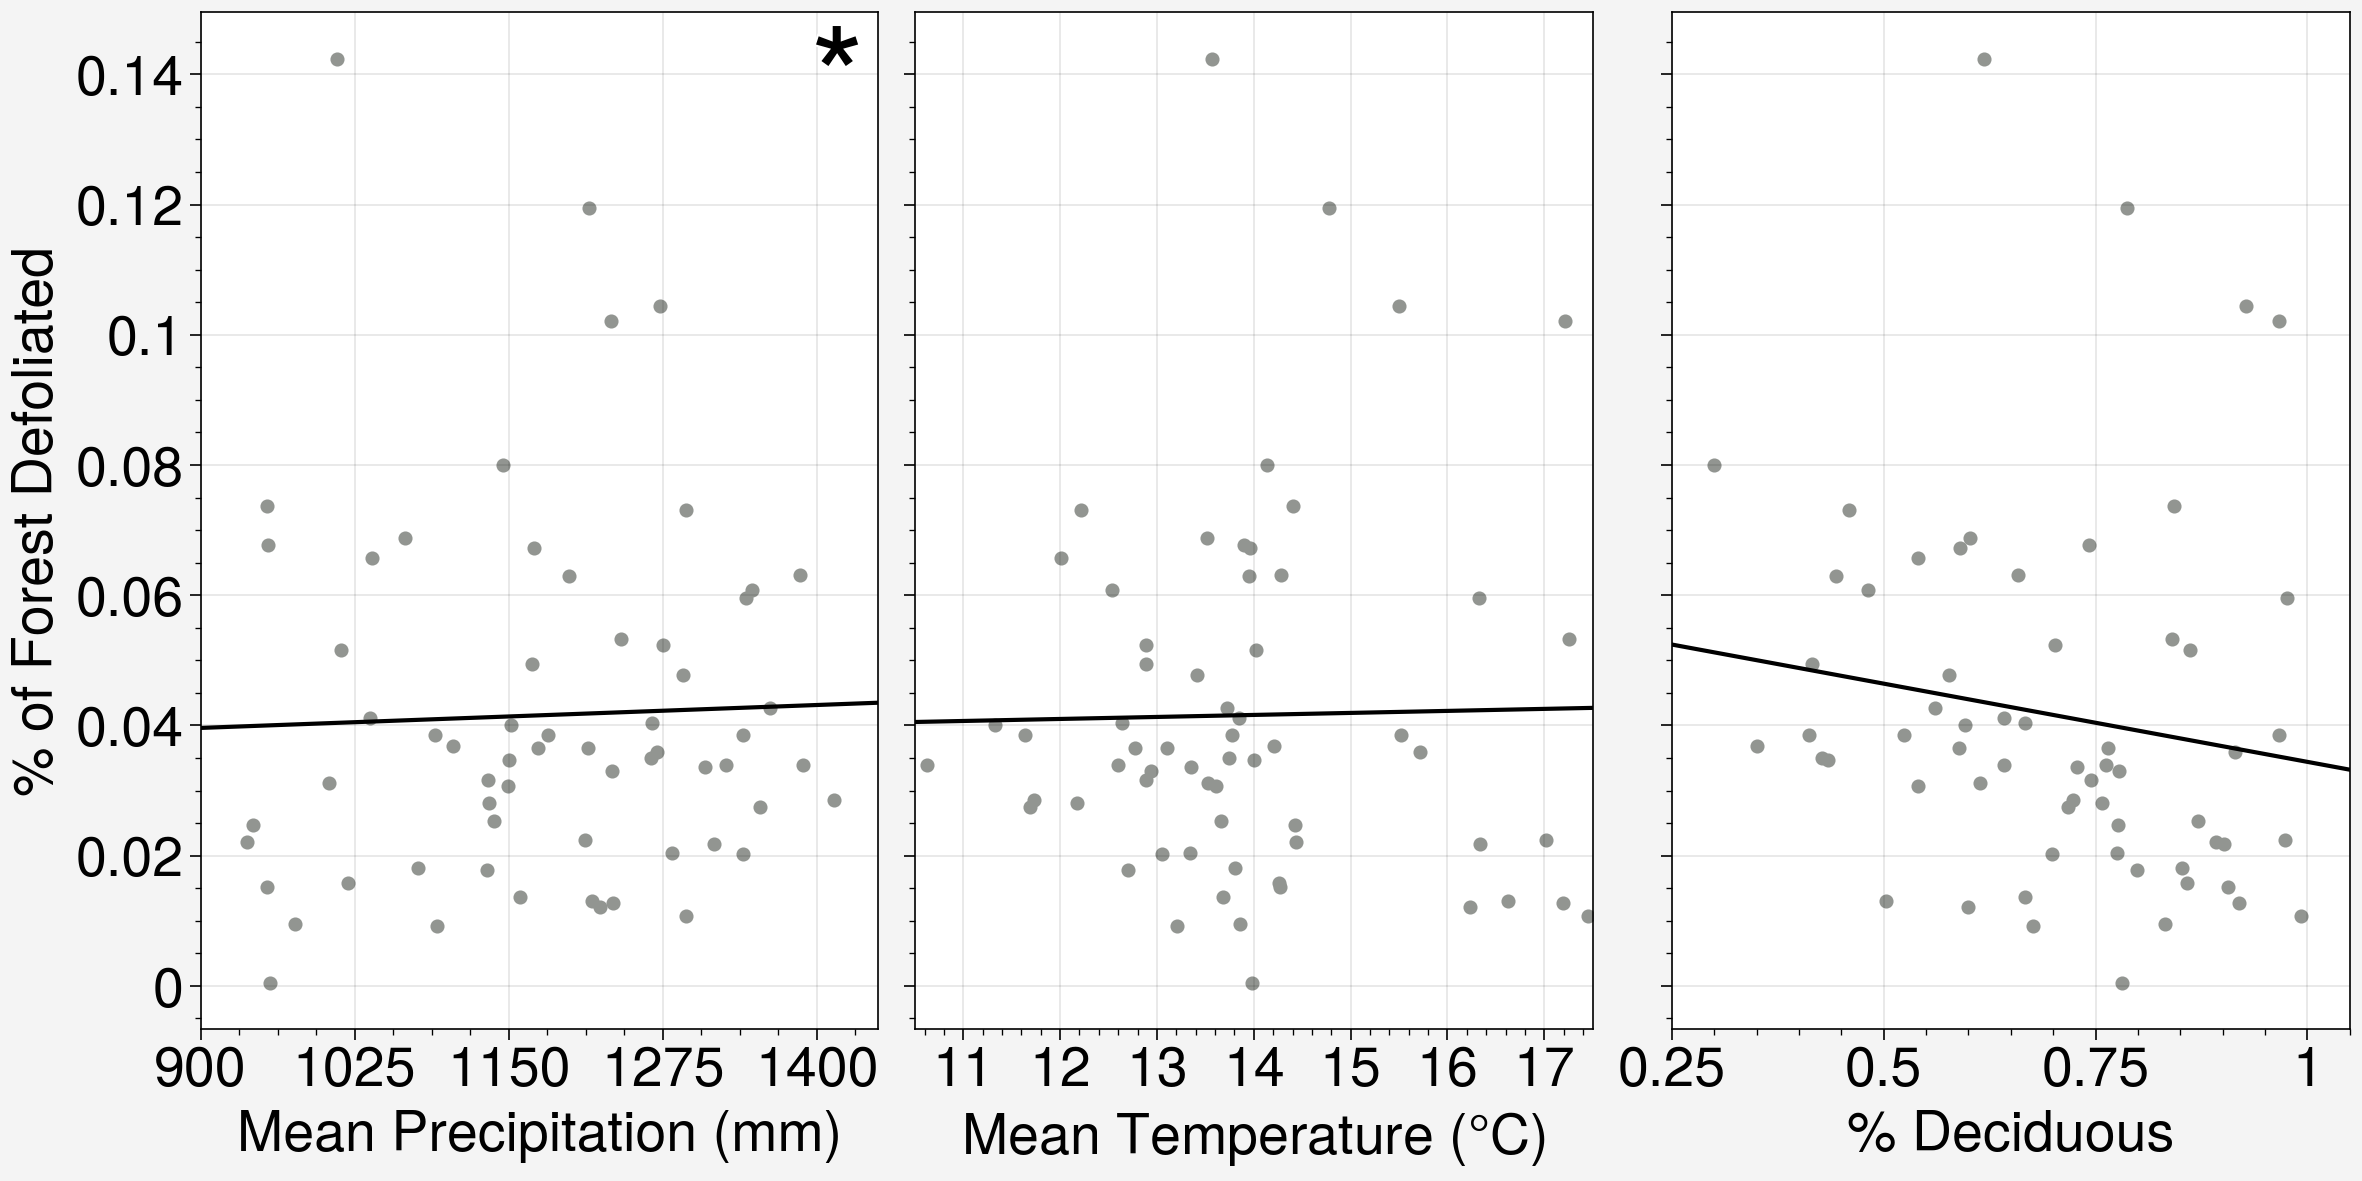

In [19]:
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("300mm", "150mm"), fontsize=20)

mod = sm.ols(formula='perc_defol_area ~ total', data=avg_defol)

res = mod.fit()

x = np.array([900, 1450])
y = res.params['Intercept'] + res.params['total']*x

axes[0].scatter(avg_defol['total'], avg_defol['perc_defol_area'], color='gray', markersize=20)
axes[0].plot(x, y, color='black')
axes[0].format(xlabel='Mean Precipitation (mm)', ylabel='% of Forest Defoliated', titleloc='ur', title='*', title_kw={'fontsize': 50}, xticks=[900, 1025, 1150, 1275, 1400])

mod = sm.ols(formula='perc_defol_area ~ tmax_mean', data=avg_defol)

res = mod.fit()

x = np.array([10.5, 17.5])
y = res.params['Intercept'] + res.params['tmax_mean']*x

axes[1].scatter(avg_defol['tmax_mean'], avg_defol['perc_defol_area'], color='gray', markersize=20)
axes[1].plot(x, y, color='black')
axes[1].format(xlabel=r'Mean Temperature ($\degree$C)', ylabel='% of Forest Defoliated')

mod = sm.ols(formula='perc_defol_area ~ perc_deciduous', data=avg_defol)

res = mod.fit()

x = np.array([0.25, 1.05])
y = res.params['Intercept'] + res.params['perc_deciduous']*x

axes[2].scatter(avg_defol['perc_deciduous'], avg_defol['perc_defol_area'], color='gray', markersize=20)
axes[2].plot(x, y, color='black')
axes[2].format(xlabel='% Deciduous', ylabel='% of Forest Defoliated', xticks=[0.25, 0.5, 0.75, 1])

fig.savefig('./Figures/Enviro/mean_regression_unscaled.png')

In [20]:
fdrcorrection([0.8338, 0.4352, 0.1654, 0.0399, 0.3929], alpha=0.15, method='indep', is_sorted=False)

(array([False, False, False, False, False]),
 array([0.8338, 0.544 , 0.4135, 0.1995, 0.544 ]))